# Analysis of dataset - world_cases_death_testing

## Environment Setup

In [1]:
from pyspark.sql import SparkSession
import pandas as pd
from pandas_profiling import ProfileReport
import seaborn as sns

spark = SparkSession.builder.getOrCreate()

## Data Import

In [2]:
filepath = 'data/part-00000-235afa9a-73a5-41a4-a764-928ced255fa7-c000.json'
dataset = spark.read.json(filepath)
dataset.createOrReplaceTempView('covid')
df_converted = dataset.toPandas()

## Data Exploration

### 1. Dataframe Size

In [3]:
print('Number of rows: ' + str(dataset.count()))


Number of rows: 59344


### 2. Data Schema

In [4]:
print('Columns names: ', dataset.columns)
dataset.printSchema()

Columns names:  ['date', 'iso_code', 'location', 'new_cases', 'new_cases_per_million', 'new_deaths', 'new_deaths_per_million', 'new_tests', 'new_tests_per_thousand', 'tests_units', 'total_cases', 'total_cases_per_million', 'total_deaths', 'total_deaths_per_million', 'total_tests', 'total_tests_per_thousand']
root
 |-- date: string (nullable = true)
 |-- iso_code: string (nullable = true)
 |-- location: string (nullable = true)
 |-- new_cases: double (nullable = true)
 |-- new_cases_per_million: double (nullable = true)
 |-- new_deaths: double (nullable = true)
 |-- new_deaths_per_million: double (nullable = true)
 |-- new_tests: double (nullable = true)
 |-- new_tests_per_thousand: double (nullable = true)
 |-- tests_units: string (nullable = true)
 |-- total_cases: double (nullable = true)
 |-- total_cases_per_million: double (nullable = true)
 |-- total_deaths: double (nullable = true)
 |-- total_deaths_per_million: double (nullable = true)
 |-- total_tests: double (nullable = true)


### 3. Null Values

In [5]:
null_values = df_converted.isna().sum()
print(null_values)

date                            0
iso_code                        0
location                        0
new_cases                     949
new_cases_per_million        1013
new_deaths                    949
new_deaths_per_million       1013
new_tests                   36462
new_tests_per_thousand      36462
tests_units                     0
total_cases                  3651
total_cases_per_million      3947
total_deaths                13226
total_deaths_per_million    13507
total_tests                 36282
total_tests_per_thousand    36282
dtype: int64


### 4. Duplicates

In [6]:
duplicates = spark.sql('''
    SELECT iso_code, date, COUNT(*)
    FROM covid
    GROUP BY iso_code, date
    HAVING COUNT(*) > 1
''').count()
print('Number of duplicates: ' + str(duplicates))

Number of duplicates: 0


### 5. Range of Values of Categorical Columns

In [7]:
print('Range of values of iso_code column: ')
print(*list(df_converted.iso_code.unique()))
print('Range of values of location column:')
print(*list(df_converted.location.unique()))

Range of values of iso_code column: 
ABW AFG AGO AIA ALB AND ARE ARG ARM ATG AUS AUT AZE BDI BEL BEN BES BFA BGD BGR BHR BHS BIH BLR BLZ BMU BOL BRA BRB BRN BTN BWA CAF CAN CHE CHL CHN CIV CMR COD COG COL COM CPV CRI CUB CUW CYM CYP CZE DEU DJI DMA DNK DOM DZA ECU EGY ERI ESH ESP EST ETH FIN FJI FLK FRA FRO GAB GBR GEO GGY GHA GIB GIN GMB GNB GNQ GRC GRD GRL GTM GUM GUY HKG HND HRV HTI HUN IDN IMN IND IRL IRN IRQ ISL ISR ITA JAM JEY JOR JPN KAZ KEN KGZ KHM KNA KOR KWT LAO LBN LBR LBY LCA LIE LKA LSO LTU LUX LVA MAR MCO MDA MDG MDV MEX MHL MKD MLI MLT MMR MNE MNG MNP MOZ MRT MSR MUS MWI MYS NAM NCL NER NGA NIC NLD NOR NPL NZL OMN PAK PAN PER PHL PNG POL PRI PRT PRY PSE PYF QAT ROU RUS RWA SAU SDN SEN SGP SLB SLE SLV SMR SOM SRB SSD STP SUR SVK SVN SWE SWZ SXM SYC SYR TCA TCD TGO THA TJK TLS TTO TUN TUR TWN TZA UGA UKR URY USA UZB VAT VCT VEN VGB VIR VNM VUT WLF OWID_KOS YEM ZAF ZMB ZWE OWID_WRL 
Range of values of location column:
Aruba Afghanistan Angola Anguilla Albania Andorra United

### 6. Range of Values of Numerical Columns

In [8]:
for column in dataset.columns:
    negative_values = dataset.filter(dataset[column] < 0.0).count()
    print('Number of negative values in ' + column + ': ' + str(negative_values))

Number of negative values in date: 0
Number of negative values in iso_code: 0
Number of negative values in location: 0
Number of negative values in new_cases: 18
Number of negative values in new_cases_per_million: 17
Number of negative values in new_deaths: 8
Number of negative values in new_deaths_per_million: 8
Number of negative values in new_tests: 6
Number of negative values in new_tests_per_thousand: 6
Number of negative values in tests_units: 0
Number of negative values in total_cases: 0
Number of negative values in total_cases_per_million: 0
Number of negative values in total_deaths: 0
Number of negative values in total_deaths_per_million: 0
Number of negative values in total_tests: 0
Number of negative values in total_tests_per_thousand: 0


### 7. Statistical Analysis

In [9]:
df_converted.describe()

,new_cases,new_cases_per_million,new_deaths,new_deaths_per_million,new_tests,new_tests_per_thousand,total_cases,total_cases_per_million,total_deaths,total_deaths_per_million,total_tests,total_tests_per_thousand
count,58395.000000,58331.000000,58395.000000,58331.000000,2.288200e+04,22882.000000,5.569300e+04,55397.000000,4.611800e+04,45837.000000,2.306200e+04,23062.000000
mean,2072.996164,42.373372,48.726877,0.729236,2.953824e+04,0.968234,1.807855e+05,3414.671026,7.137943e+03,99.739999,2.496756e+06,86.762391
std,19578.717767,139.368046,407.140949,3.137522,1.195083e+05,1.781220,1.832069e+06,6740.198294,5.820664e+04,186.196975,1.141408e+07,173.632077
min,-8261.000000,-2212.545000,-1918.000000,-67.901000,-3.743000e+03,-0.398000,1.000000e+00,0.001000,1.000000e+00,0.000000,1.000000e+00,0.000000
25%,0.000000,0.000000,0.000000,0.000000,1.075000e+03,0.076000,1.890000e+02,95.477000,1.300000e+01,4.199000,6.558175e+04,4.437250
50%,14.000000,2.303000,0.000000,0.000000,3.879000e+03,0.358000,2.224000e+03,642.841000,8.900000e+01,21.692000,2.907275e+05,23.132500
75%,251.000000,27.724500,4.000000,0.309000,1.442575e+04,1.139000,2.488300e+04,3719.324000,7.730000e+02,99.425000,1.154340e+06,93.413250
max,679514.000000,8652.658000,12135.000000,215.382000,1.741517e+06,26.137000,6.052694e+07,83194.202000,1.422753e+06,1378.562000,1.815069e+08,2116.722000


In [10]:
profile = ProfileReport(df_converted)
profile.to_file(output_file='output.html')

### 8. Visualization of Data

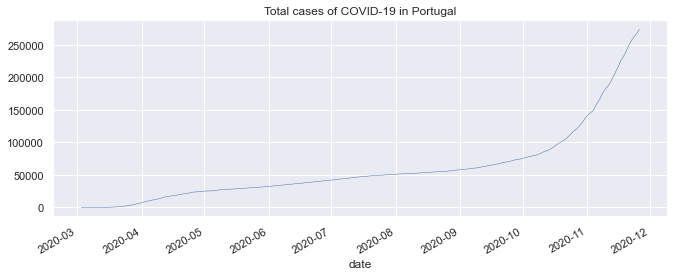

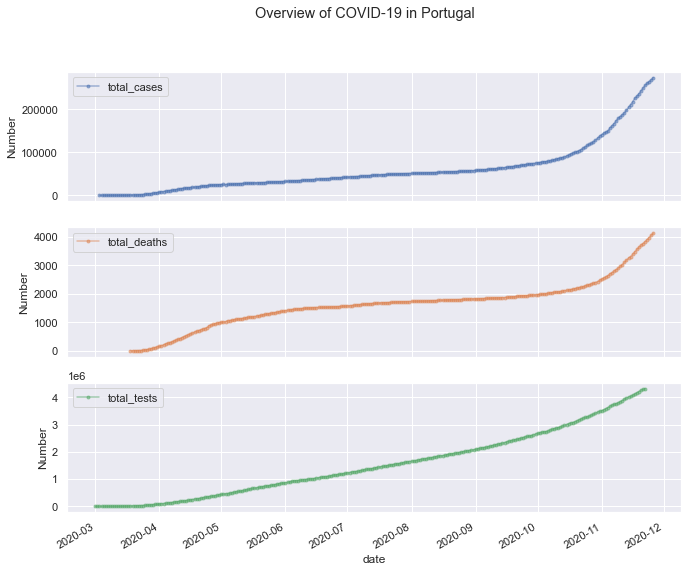

In [11]:
df_converted['date'] = pd.to_datetime(df_converted['date'])
df_converted = df_converted.set_index('date')
prt_data = df_converted[df_converted['iso_code'] == 'PRT']

sns.set(rc={'figure.figsize':(11,4)})
prt_data['total_cases'].plot(linewidth=0.5,
                             title='Total cases of COVID-19 in Portugal')

colums = ['total_cases', 'total_deaths', 'total_tests']
axes = prt_data[colums].plot(marker='.',
                             alpha=0.5,
                             figsize=(11, 9),
                             subplots=True,
                             title='Overview of COVID-19 in Portugal')
for axi in axes:
    axi.set_ylabel('Number')